# FINM 34700 Quantitative Trading Strartegy

Homework-2 Submitted by Vidhan Ajmera\
Email: vidhanajmera@uchicago.edu

# Futures Spread Trading: Gold Miners ETF series

## Sections
1. Objectives
2. Helper Functions
3. Data Import and cleaning
4. Trading Algorithm
4. Result Analysis and Comparision
5. Conclusion

# 1. Objective

In this homework, we discuss a spread trading strategy using the daily close prices of 2 highly correlated ETFs, namely:

-  iShares MSCI Global Gold Miners ETF (RING)
-  VanEck Gold Miners ETF (GDX)

The iShares MSCI Global Gold Miners ETF seeks to track the investment results of an index composed of global equities of companies primarily engaged in the business of gold mining. Whereas, the VanEck Gold Miners ETF seeks to replicate as closely as possible, before fees and expenses, the price and yield performance of the NYSE Arca Gold Miners Index. Both these ETFs are fairly used by portfolio investors for diversification purpose.

As daily return time-series of both the securities are highly correlated with correlation coefficient 98.92%, I can safely assume that the spread between them follows characterstics of mean reversion. At the same time, one series (RING) is far more liquid than the other series(GDX) and it can be observed that there are some deviations in returns at a daily level.

Our objective is to build and perform analysis of a trading strategy that generates buy signals if the return spread is negative and sell signals if the return spread is positive. Next, I have generated performance statistics for return analysis. Lastly, I have tried to find the best parameters to use for such a strategy and the correlation of such a strategy's returns with Fama-French style factors.
    
 Important variables that could be subsequently analyzed are:
1. Nt- running median of less liquid of the two ETFs
2. g - This is the threshold level for entering the contract for the strategy. f the M days average return spread exceeds g, we should enter the strategy
3. j - Once the strategy is live, if the M days spread comes below j, we should exit the strategy
4. M- Window size for computing the average of daily returns. As the returns on any given day could be volatile, we would take M Day rolling window to allow smoothening of the spread
5. s (Stop Loss Threshold)- If the strategy losses this proportion of amount relative to the Gross Cash value of strategy, the strategy is pre-maturly exited, the losses are liquidated and we do not trade for the remainder of the month
We play with M, g, j and s to see how our strategy performs under different scenarios.

For this homework, we need to take into account the major events that occured during the given time period. For instance, the impact of spread of the financial contagion that has made headlines up until today, Covid-19 pandemic, Russia's invasion of Ukraine and rising inflation in US economy.

# 2. Helper Functions

This section includes the import of relevant libraries and defining the functions for fetching, generating, plotting and analyzing the spreads.\
I have leveraged caching for storing the data fetched from Nasdaq Data Link.

In [1]:
import numpy as np
import pandas as pd
import nasdaqdatalink
import scipy.stats as ss
import seaborn as sns
from functools import lru_cache
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import datetime
import pandas_datareader as pdr
import warnings
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15,10]
warnings.filterwarnings('ignore')

In [2]:
@lru_cache(maxsize=1600)
def fetch_data(start,end):
    '''
    This function helps in fetching data from Nasdaq Data Link
    
    '''
    rawdata = nasdaqdatalink.get_table('QUOTEMEDIA/PRICES', ticker = ['RING','GDX'], qopts={"columns":["ticker","date","adj_close","adj_volume"]}, date = { 'gte': start, 'lte': end }).iloc[::-1]
    rawdata.set_index('date',inplace=True)
    x=rawdata[rawdata['ticker'] == 'RING']
    y= rawdata[rawdata['ticker'] == 'GDX']
    df= pd.concat([x,y],axis=1)
    df.columns = [ 'R-ticker', 'RINGadj_close', 'RINGadj_vol', 'G-ticker','GDXadj_close', 'GDXadj_vol']
    df.drop(columns=['R-ticker','G-ticker'], inplace=True)
    return df
    

In [22]:
def tradingexecution(M,g,j,s):
    '''
    This function is designed to take 4 Parameters as input and generate a trading strategy
    over the given time series. Here I have assumed the dates are provided in advance and 
    the dataframe is available with relevent columns and time series data for return spread.
    '''
    
    ind=['2020-12','2021-01','2021-02','2021-03','2021-04','2021-05','2021-06',\
         '2021-07','2021-08','2021-09','2021-10','2021-11','2021-12','2022-01',\
         '2022-02','2022-03','2022-04','2022-05','2022-06','2022-07','2022-08','2022-09','2022-10','2022-11']
    data=df.copy()
    data['rolling_spread'] = data['Spread'].rolling(M).mean()
    data.dropna(inplace=True)
    bullspread = []
    bearspread = []  
    stopLoss = []
    monthEnd = []
    for period in ind:
        first = data.loc[period].iloc[0].name
        data.loc[first,'cumPnL'] = data.iloc[data.index.get_loc(first)-1]['cumPnL']
        if data.loc[first,'rolling_spread'] > g:
            data.loc[first,'action'] = -1
            bearspread.append(first)
        elif data.loc[first,'rolling_spread'] < -g:
            data.loc[first,'action'] = 1
            bullspread.append(first)
        if data.loc[first,'action'] != 0:            
            volume = data.loc[first,'Nt']/100            
            data.loc[first,'N_RING'] = data.loc[first,'action']*round(volume/data.loc[first,'RINGadj_close'],0)            
            data.loc[first,'N_GDX'] = -data.loc[first,'action']*round(volume/data.loc[first,'GDXadj_close'],0)            
            data.loc[first,'positionValue'] = data.loc[first,'N_RING'] * data.loc[first,'RINGadj_close'] + data.loc[first,'N_GDX'] * data.loc[first,'GDXadj_close']
            data.loc[first,'grossCash'] = abs(data.loc[first,'N_RING'] * data.loc[first,'RINGadj_close']) + abs(data.loc[first,'N_GDX'] * data.loc[first,'GDXadj_close'])
        for i, row in data.loc[period].iloc[1:-1].iterrows():           
            if data.iloc[data.index.get_loc(i)-1]['action'] == 0:
                if data.loc[i,'rolling_spread'] > g:                    
                    data.loc[i,'action'] = -1
                    bearspread.append(i)
                elif data.loc[i,'rolling_spread'] < -g:
                    data.loc[i,'action'] = 1 
                    bullspread.append(i)
                else:
                    data.loc[i,'cumPnL'] = data.iloc[data.index.get_loc(i)-1]['cumPnL']
                    continue
                volume = data.loc[i,'Nt']/100
                data.loc[i,'N_RING'] = data.loc[i,'action']*round(volume/data.loc[i,'RINGadj_close'],0) 
                data.loc[i,'N_GDX'] = -data.loc[i,'action']*round(volume/data.loc[i,'GDXadj_close'],0) 
                data.loc[i,'positionValue'] = data.loc[i,'N_RING'] * data.loc[i,'RINGadj_close'] + data.loc[i,'N_GDX'] * data.loc[i,'GDXadj_close']
                data.loc[i,'grossCash'] = abs(data.loc[i,'N_RING'] * data.loc[i,'RINGadj_close']) + abs(data.loc[i,'N_GDX'] * data.loc[i,'GDXadj_close'])        
                data.loc[i,'cumPnL'] = data.iloc[data.index.get_loc(i)-1]['cumPnL']                
            elif data.iloc[data.index.get_loc(i)-1]['action'] == -1:                
                data.loc[i,'positionValue'] = data.iloc[data.index.get_loc(i)-1]['N_RING']*data.loc[i,'RINGadj_close']+ data.iloc[data.index.get_loc(i)-1]['N_GDX']*data.loc[i,'GDXadj_close']
                data.loc[i,'Daily_PnL'] = data.loc[i,'positionValue'] - data.iloc[data.index.get_loc(i)-1]['positionValue']
                data.loc[i,'cumPnL'] = data.iloc[data.index.get_loc(i)-1]['cumPnL'] + data.loc[i,'Daily_PnL']
                data.loc[i,'positionPnL'] = data.iloc[data.index.get_loc(i)-1]['positionPnL'] + data.loc[i,'Daily_PnL']
                data.loc[i,'grossCash'] = data.iloc[data.index.get_loc(i)-1]['grossCash']          
                if data.loc[i,'positionPnL']/data.loc[i,'grossCash'] < s:                    
                    data.loc[i,'action'] = 0
                    data.loc[i,'N_RING'] = 0
                    data.loc[i,'N_GDX'] = 0
                    data.loc[i,'grossCash'] = 0
                    data.loc[i,'positionPnL'] = 0
                    data.loc[i:,'cumPnL'] = data.loc[i,'cumPnL']
                    data.loc[i,'positionValue'] = data.loc[i,'N_RING']*data.loc[i,'RINGadj_close']+ data.loc[i,'N_GDX']*data.loc[i,'GDXadj_close']
                    stopLoss.append(i)
                    break
                elif data.loc[i,'rolling_spread'] < -g:                    
                    data.loc[i]['action'] = 1                    
                    volume = data.loc[i,'Nt']/100
                    data.loc[i,'N_RING'] = data.loc[i,'action']*round(volume/data.loc[i,'RINGadj_close'],0)
                    data.loc[i,'N_GDX'] = -data.loc[i,'action']*round(volume/data.loc[i,'GDXadj_close'],0)
                    data.loc[i,'grossCash'] = abs(data.loc[i,'N_RING'] * data.loc[i,'RINGadj_close']) + abs(data.loc[i,'N_GDX'] * data.loc[i,'GDXadj_close'])                    
                    data.loc[i,'positionPnL'] = 0
                    data.loc[i,'positionValue'] = data.loc[i,'N_RING']*data.loc[i,'RINGadj_close']+ data.loc[i,'N_GDX']*data.loc[i,'GDXadj_close']                        
                    bullspread.append(i)
                elif data.loc[i,'rolling_spread'] < j:                    
                    data.loc[i,'action'] = 0
                    data.loc[i,'N_RING'] = 0
                    data.loc[i,'N_GDX'] = 0
                    data.loc[i,'grossCash'] = 0
                    data.loc[i,'positionPnL'] = 0
                    data.loc[i,'positionValue'] = data.loc[i,'N_RING']*data.loc[i,'RINGadj_close']+ data.loc[i,'N_GDX']*data.loc[i,'GDXadj_close']                        
                    bullspread.append(i)
                else:
                    data.loc[i,'action'] = data.iloc[data.index.get_loc(i)-1]['action']
                    data.loc[i,'N_RING'] = data.iloc[data.index.get_loc(i)-1]['N_RING']
                    data.loc[i,'N_GDX'] = data.iloc[data.index.get_loc(i)-1]['N_GDX']
            elif data.iloc[data.index.get_loc(i)-1]['action'] == 1:                
                data.loc[i,'positionValue'] = data.iloc[data.index.get_loc(i)-1]['N_RING']*data.loc[i,'RINGadj_close']+ data.iloc[data.index.get_loc(i)-1]['N_GDX']*data.loc[i,'GDXadj_close']
                data.loc[i,'Daily_PnL'] = data.loc[i,'positionValue'] - data.iloc[data.index.get_loc(i)-1]['positionValue']
                data.loc[i,'cumPnL'] = data.iloc[data.index.get_loc(i)-1]['cumPnL'] + data.loc[i,'Daily_PnL']
                data.loc[i,'positionPnL'] = data.iloc[data.index.get_loc(i)-1]['positionPnL'] + data.loc[i,'Daily_PnL']
                data.loc[i,'grossCash'] = data.iloc[data.index.get_loc(i)-1]['grossCash']

                if data.loc[i,'positionPnL']/data.loc[i,'grossCash'] < s:
                    data.loc[i,'action'] = 0
                    data.loc[i,'N_RING'] = 0
                    data.loc[i,'N_GDX'] = 0
                    data.loc[i,'grossCash'] = 0
                    data.loc[i,'positionPnL'] = 0
                    data.loc[i:,'cumPnL'] = data.loc[i,'cumPnL']
                    data.loc[i,'positionValue'] = data.loc[i,'N_RING']*data.loc[i,'RINGadj_close']+ data.loc[i,'N_GDX']*data.loc[i,'GDXadj_close']
                    stopLoss.append(i)
                    break
                elif data.loc[i,'rolling_spread'] > g:

                    data.loc[i]['action'] = -1
                    volume = data.loc[i,'Nt']/100
                    data.loc[i,'N_RING'] = data.loc[i,'action']*round(volume/data.loc[i,'RINGadj_close'],0)
                    data.loc[i,'N_GDX'] = -data.loc[i,'action']*round(volume/data.loc[i,'GDXadj_close'],0)
                    data.loc[i,'grossCash'] = abs(data.loc[i,'N_RING'] * data.loc[i,'RINGadj_close']) \
                                            + abs(data.loc[i,'N_GDX'] * data.loc[i,'GDXadj_close'])

                    data.loc[i,'positionPnL'] = 0
                    data.loc[i,'positionValue'] = data.loc[i,'N_RING']*data.loc[i,'RINGadj_close']\
                                            + data.loc[i,'N_GDX']*data.loc[i,'GDXadj_close']                        
                    bearspread.append(i)
                elif data.loc[i,'rolling_spread'] > j:
                    data.loc[i,'action'] = 0
                    data.loc[i,'N_RING'] = 0
                    data.loc[i,'N_GDX'] = 0
                    data.loc[i,'grossCash'] = 0
                    data.loc[i,'positionPnL'] = 0
                    data.loc[i,'positionValue'] = data.loc[i,'N_RING']*data.loc[i,'RINGadj_close']+ data.loc[i,'N_GDX']*data.loc[i,'GDXadj_close']                        
                    bearspread.append(i)
                else:
                    data.loc[i,'action'] = data.iloc[data.index.get_loc(i)-1]['action']
                    data.loc[i,'N_RING'] = data.iloc[data.index.get_loc(i)-1]['N_RING']
                    data.loc[i,'N_GDX'] = data.iloc[data.index.get_loc(i)-1]['N_GDX']
        last = data.loc[period].iloc[-1].name
        if data.iloc[data.index.get_loc(last)-1]['action'] != 0:                   
            data.loc[last,'positionValue'] = data.iloc[data.index.get_loc(last)-1]['N_RING']*data.loc[last,'RINGadj_close'] + data.iloc[data.index.get_loc(last)-1]['N_GDX']*data.loc[last,'GDXadj_close']
            data.loc[last,'Daily_PnL'] = data.loc[last,'positionValue'] - data.iloc[data.index.get_loc(last)-1]['positionValue']
            data.loc[last,'cumPnL'] = data.iloc[data.index.get_loc(last)-1]['cumPnL'] + data.loc[last,'Daily_PnL']
            data.loc[last,'action'] = 0
            data.loc[last,'N_RING'] = 0
            data.loc[last,'N_GDX'] = 0
            data.loc[last,'grossCash'] = 0
            data.loc[last,'positionPnL'] = 0
            data.loc[last,'positionValue'] = 0                
            monthEnd.append(last)
        else:
            data.loc[last,'cumPnL'] = data.iloc[data.index.get_loc(last)-1]['cumPnL']
    res=[bullspread,bearspread,monthEnd,stopLoss]
    return data,res

In [4]:
def strategyplot(data,M,g,j,bullspread,bearspread,monthEnd,stopLoss,p):  
    '''
    For given outputs of trading execution function, the function gives the series of subplots with trading thresholds and Buy/Sell points.
    '''
    
    plt.plot(data.rolling_spread,label = str(M) + ' day rolling spread returns')
    plt.scatter(bullspread,[data.loc[i]['rolling_spread'] for i in bullspread],color='g',label = 'Bull Spreads')
    plt.scatter(bearspread,[data.loc[i]['rolling_spread'] for i in bearspread],color='r',label = 'Bear Spreads')
    plt.scatter(monthEnd,[data.loc[i]['rolling_spread'] for i in monthEnd],color='c',label = 'Monthly  Close')
    plt.scatter(stopLoss,[data.loc[i]['rolling_spread'] for i in stopLoss],color='m',label = 'Stop Losses')    
    plt.axhline(y= g, color='k', linestyle='-',label = 'g = '+str(g))
    plt.axhline(y=-g, color='k', linestyle='-')    
    plt.axhline(y= j, color='yellow', linestyle='-',label = 'j = '+str(j))
    plt.axhline(y=-j, color='yellow', linestyle='-')   
    plt.ylabel("Spread",fontsize = 12)    
    plt.xlabel("Date",fontsize = 12)
    profit = data.cumPnL[-1]
    capital = 2*data['Nt'].max()/100
    roc = 100*profit/capital 
    b = len(bullspread)
    s = len(bearspread)
    l = len(stopLoss)
    m = len(monthEnd) 
    plt.title(f" Plot -{p} Net Profit from strategy in $ = {int(profit)}  & Return on Capital = {round(roc,1)}%",fontsize = 16)
    plt.legend()
    plt.show()

In [5]:
def returnstats(df):
    '''
        The function provides performance statistics for a given daily return series 
        Inputs: return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output: summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Var (0.5),Skewness and Excess Kurtosis based on monthly returns.
    '''        
    summary = pd.DataFrame(index = df.columns)    
    summary['Annualized Mean'] = df.mean()*252
    summary['Annualized Volatility'] = df.std()*np.sqrt(252)
    summary['Sharpe Ratio'] = summary['Annualized Mean']/summary['Annualized Volatility']    
    summary['Skewness'] = df.skew()
    summary['95% VaR'] = df.quantile(0.05)
    summary['Excess Kurtosis'] = df.kurt()
    
    return summary

# 3. Data Importing and Cleaning

The two ETFs that are selected based on student ID are related as follows:\
A)  iShares MSCI Global Gold Miners ETF (RING)\
B)  VanEck Gold Miners ETF (GDX)

We use Nasdaq Data Link API function to fetch the data for these two securities by using 

In [3]:
nasdaqdatalink.ApiConfig.api_key = 'CamMX_TXJSsCy6ta9dqj'

In [7]:
df=fetch_data('2020-12-02','2022-11-15')

In [8]:
df

,RINGadj_close,RINGadj_vol,GDXadj_close,GDXadj_vol
date,,,,
2020-12-02,28.264378,243874.0,35.168222,23716488.0
2020-12-03,27.969263,102642.0,34.718475,21086514.0
2020-12-04,27.797906,900411.0,34.522933,15642110.0
2020-12-07,28.816528,205666.0,35.686408,26560182.0
2020-12-08,28.721330,70002.0,35.539751,15020976.0
...,...,...,...,...
2022-11-09,19.773971,33527.0,26.240000,31642844.0
2022-11-10,21.295046,81007.0,28.210000,46831349.0
2022-11-11,21.364186,104037.0,28.300000,23145736.0


Here, I have compute the 15-Day rolling median of Volumes for the two series along with $N_t$ as the minimum of the dollor volumns of the two series. I have defined the return spread as :

Return Spread = Returns on iShares MSCI Global Gold Miners ETF - Returns on VanEck Gold Miners ETF

<b> Data Processing </b>

In [9]:
df['Rol_Median_RING'] = (df['RINGadj_close']*df['RINGadj_vol']).rolling(15, closed='left').median()
df['Rol_Median_GDX'] = (df['GDXadj_close']*df['GDXadj_vol']).rolling(15, closed='left').median()
df['Nt'] = df[['Rol_Median_RING','Rol_Median_GDX']].min(axis = 1)
df['ret_RING'] = df['RINGadj_close'].pct_change()
df['ret_GDX'] = df['GDXadj_close'].pct_change()
df['Spread'] =  (df['ret_RING']-df['ret_GDX'])
df = df.drop(columns=['RINGadj_vol','GDXadj_vol','Rol_Median_RING','Rol_Median_GDX'])

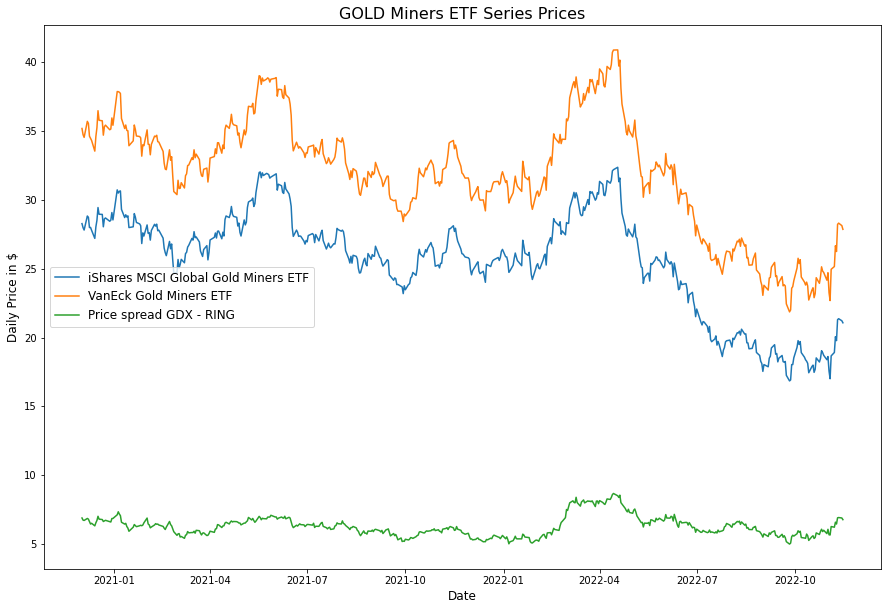

In [10]:
plt.plot(df.RINGadj_close, label = "iShares MSCI Global Gold Miners ETF")
plt.plot(df.GDXadj_close, label = "VanEck Gold Miners ETF" )
plt.plot(df.GDXadj_close-df.RINGadj_close, label = "Price spread GDX - RING" )
plt.legend(fontsize = 12)
plt.xlabel('Date',fontsize = 12)
plt.ylabel('Daily Price in $',fontsize = 12)
plt.title("GOLD Miners ETF Series Prices",fontsize = 16)
plt.show()

<b> Observation </b> : As can be observed from the graph, both the time serieses are highly correlated.

In [11]:
returnstats(df[['ret_RING','ret_GDX']])

,Annualized Mean,Annualized Volatility,Sharpe Ratio,Skewness,95% VaR,Excess Kurtosis
ret_RING,-0.091546,0.344438,-0.265782,0.412586,-0.034291,1.346571
ret_GDX,-0.059951,0.346194,-0.173172,0.404360,-0.034501,1.386906


<b> Observation </b> : From the tabel above, annualized mean returns are negative for both the spreads over the given period. The volatility seems to be to be almost similar for both serieses. As seen from the risk metrics, these return have fat tails for both the serieses. 

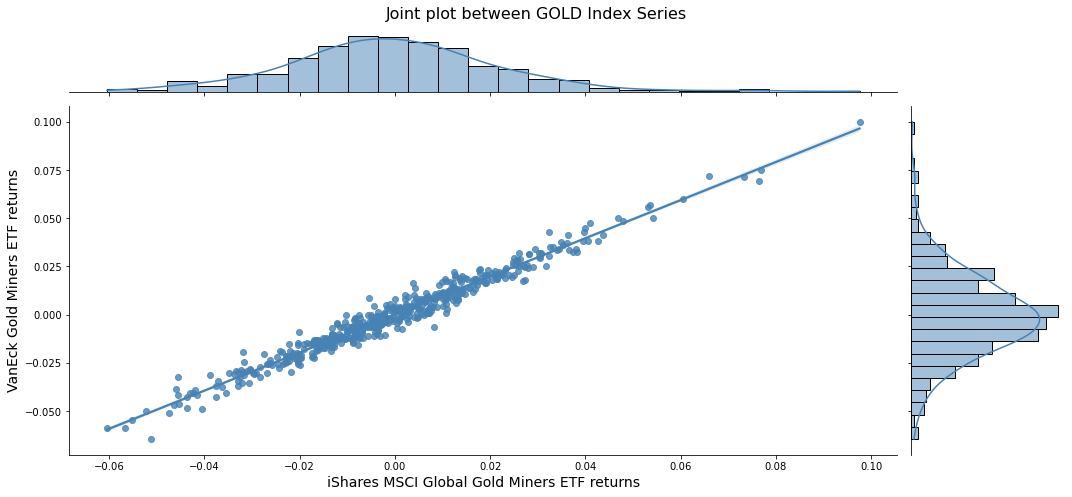

In [12]:
p = sns.jointplot(x = df['ret_RING'],y = df['ret_GDX'],kind='reg',color='steelblue')
p.fig.set_figwidth(15)
p.fig.set_figheight(7)
p.set_axis_labels('iShares MSCI Global Gold Miners ETF returns', 'VanEck Gold Miners ETF returns', fontsize=14)
p.fig.suptitle("Joint plot between GOLD Index Series",fontsize=16)
p.fig.tight_layout()

<b> Observation </b> From the figure above, 'iShares MSCI Global Gold Miners ETF returns' series is closer to Normal distribution whereas  'VanEck Gold Miners ETF returns' series is more closely cenetered around the mean.

# 4. Trading Algorithm
Here I have tried to build a trading strategy based on the assumptions and guidelines described in the Homework document(PDF). As suggested in the PDF, I would try to maximize the trading algorithm by modifying 4 parameters viz. M, g, j and s, and check that what combination of these four parameters provide the highest return on capital.

In [13]:
df['action'] = 0
df['N_RING'] = 0
df['N_GDX'] = 0
df['positionValue'] = 0
df['Daily_PnL'] = 0
df['positionPnL'] = 0
df['cumPnL'] = 0
df['grossCash'] = 0
M=1
g=.0011
j=.00016
s=-0.0001
x,y=tradingexecution(M,g,j,s)

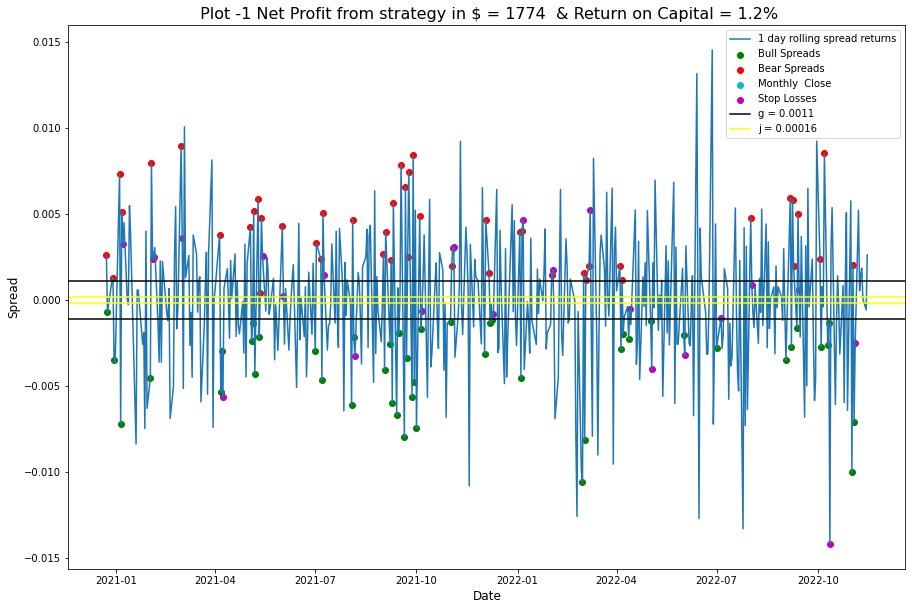

In [14]:
strategyplot(x,M,g,j,y[0],y[1],y[2],y[3],1)

<b> Observations: </b><br>
1. The strategy is not very profitable. Cost of carrying out the number of transactions is going to make it a non-profitable investment.
2. The strategy has too many stop loss thresholds that are impacting the profitability in a big way
3. The return series had a volatile period during March 2022 and July 2022. These months correspond to Russia Ukraine war and EU ban on Russian imports.

# 5. Result Analysis and Comparision with FF factors


Here we analyse the trading strategy's sensitivity to 4 differernt input parameters. Although there is no linear relationship between the inputs and the Net PNL

<b> 5.1 Impact of Stop Loss </b>

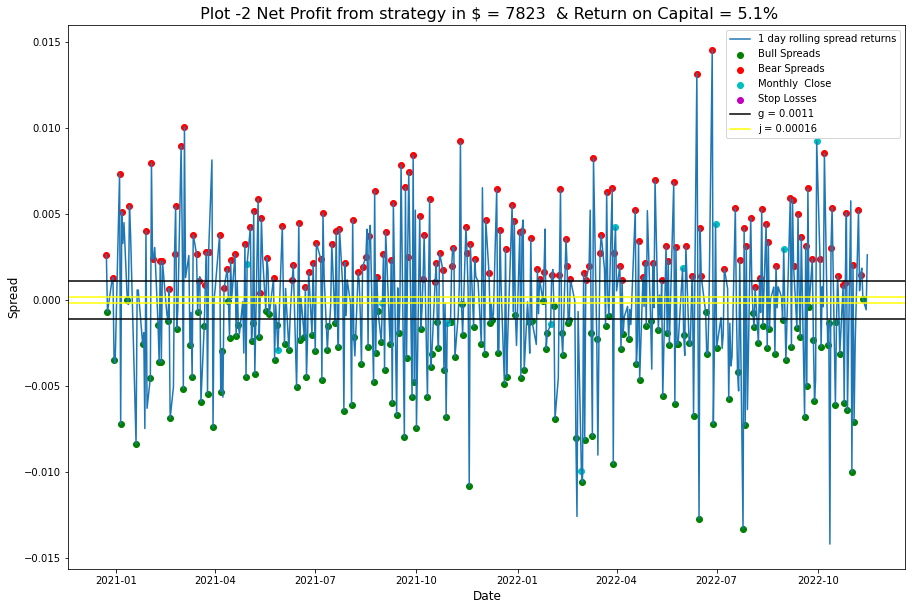

In [15]:
M=1
g=.0011
j=.00016
s=-0.01
x,y=tradingexecution(M,g,j,s)
strategyplot(x,M,g,j,y[0],y[1],y[2],y[3],2)

<b> Observation </b> Comparing the two graphs representing the trading strategy with two different values of stoplosses i.e. Plot-1 with Return on capital of 1.2% has a stop loss of 0.0001, and Plot-2 with Return on capital of 5.1% has a stop loss of 0.01. As can be observed, increasing the stop loss has a direct impact on the return on capital. <b> This suggests that for such mean reverting time series, we can improve the profitability and bet on the reversion of spread by using a strict stop loss values.

<b> 5.2 Impact of M-day Moving average parameter</b>

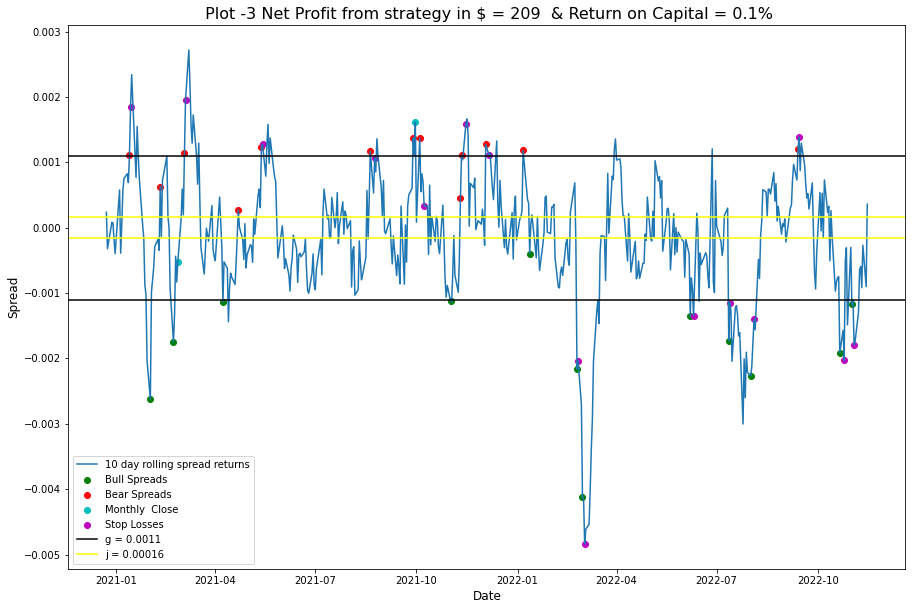

In [16]:
M=10
g=.0011
j=.00016
s=-0.0001
x,y=tradingexecution(M,g,j,s)
strategyplot(x,M,g,j,y[0],y[1],y[2],y[3],3)

<b> Observation </b> Comparing the two graphs representing the trading strategy with two different values of Moving day averages i.e. Plot-1 with Return on capital of 1.2% has a Moving day average of 1 day of 0.0001, and Plot-3 with Return on capital of 0.1% has a moving day average of 10 days. As can be observed, increasing the value of M does not bode well with the returns on investment. <b>This suggests a lower M-day average would be better for trading such reverting spreads. Also, volatility spike in the month of March-2022 could have been improved by going lenient on stoploss.

<b> 5.3  Optimal parameters for entering and exiting the spread </b>

Here, we use hit and trial method to analyse the behaviour of objective function( Return on capital) based on changing parameters. We find that following values of these parameters give highest Return on investment.

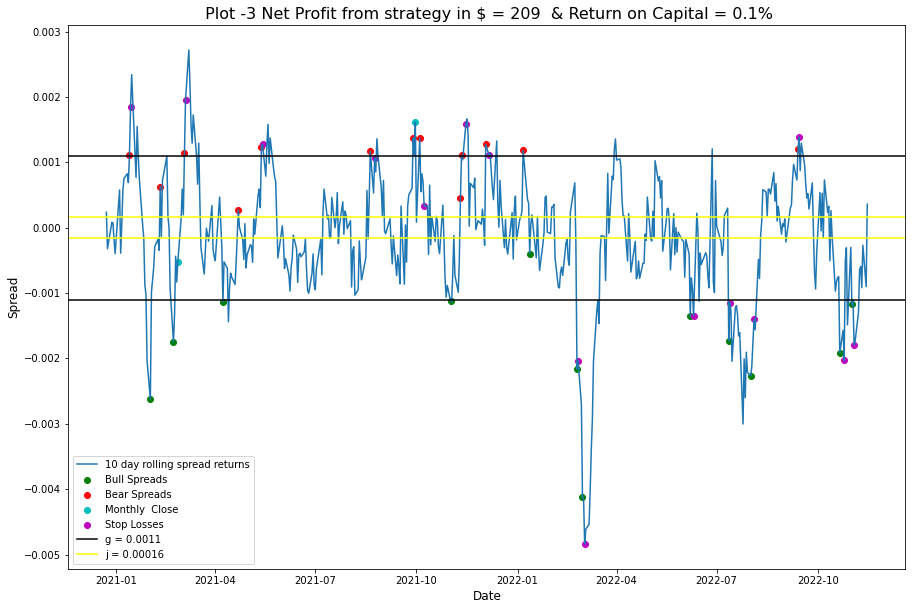

In [17]:
M=10
g=.0011
j=.00016
s=-0.0001
x,y=tradingexecution(M,g,j,s)
strategyplot(x,M,g,j,y[0],y[1],y[2],y[3],3)

<b> 5.4 Comparing returns with Fama French Factor  </b>

Next, I have compared the return on my trading strategy with daily returns of Fama French's three factors namely We begin by importing the Fama-French 3-factor returns and computing the returns (on Cumulative P&L) of our trading strategies. 

In [18]:
factor_return = pdr.DataReader("F-F_Research_Data_Factors_daily","famafrench",'2020-12-02','2022-11-15')[0]/100
factor_return.describe()

,Mkt-RF,SMB,HML,RF
count,493.000000,493.000000,493.000000,493.000000
mean,0.000192,-0.000010,0.000895,0.000019
std,0.012728,0.007853,0.011921,0.000037
min,-0.042900,-0.027100,-0.038600,0.000000
25%,-0.007100,-0.005200,-0.007100,0.000000
50%,0.000400,-0.000300,0.000900,0.000000
75%,0.007800,0.005300,0.008400,0.000010
max,0.056800,0.021400,0.039300,0.000140


In [19]:
df_factors=pd.merge(df, factor_return, left_index=True, right_index=True)
df_factors=df_factors.drop(columns=['RINGadj_close','GDXadj_close','Nt','action', 'N_RING', 'N_GDX', 'positionValue', 'Daily_PnL', 'positionPnL','cumPnL','grossCash' ],axis=1)
df_factors.dropna(inplace=True)

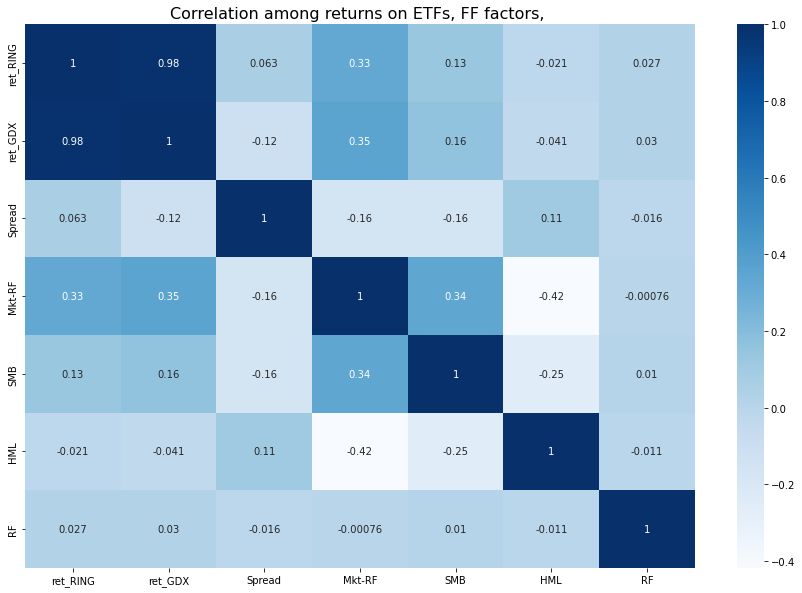

In [20]:
sns.heatmap(df_factors.corr(),annot=True,cmap='Blues')
plt.title("Correlation among returns on ETFs, FF factors, ", fontsize = 16)
plt.show()

<b> Observation </b> From the figure above, the two ETF serieses have correlation coeficient of 98%. Other important thing to notice is that there is very low correlation between daily return spread and fama french factors. Our strategy is 1-day moving average, which is same as daily return spread. Hence, it can be observed that the returns on my strategy are not correlated with Fama French factors. We can conduct a regression analysis to confirm the observation.

In [21]:
fac=df_factors.drop(columns=['ret_RING','ret_GDX','Spread','RF'],axis=1)
port=df_factors['Spread']
FACT=fac.columns
y = port
X = sm.add_constant(fac)
model=sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Spread   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     6.467
Date:                Thu, 19 Jan 2023   Prob (F-statistic):           0.000268
Time:                        22:19:29   Log-Likelihood:                 2032.6
No. Observations:                 492   AIC:                            -4057.
Df Residuals:                     488   BIC:                            -4040.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.740      0.4

<b> Observation </b> From regression analysis, I could see that the p-values for the betas are coming out to be higher than 0.05 for HML, which suggests that the HML-Beta is statistically insignificant. The R-squared value of 0.038 suggests the very less amount of variance in strategy-return explained by the FF factors. A high conditional number of 140 suggests multicolinearity.

# 6. Conclusion

Following is a breif summary of observations and conclusions from the trading strategy simulation and analysis:


1. This is a theoretical excercise. I have assumed the transaction/ trading costs are negligible but that would definitely eat into the profits as the number of trades increase.
2. It can be observed that the time serieses are highly correlated, with result in the spread to converge at a faster rate.
3. The choice of stop loss parameter matters alot in terms of impact on overall profit margin.
4. M-day moving average for trading Gold ETF spread should be close to daily average, since the highly close movements of both the ETF serieses.
5. Zero to negative correlation with Fama French factors suggests inflation hedging property of investing in Gold as an asset class.
